In [1]:
import matplotlib
import pathlib

import mne
print(mne.__version__)
import mne_bids

matplotlib.use('Qt5Agg')



0.22.1


In [2]:
raw = mne.io.read_raw_eeglab('sub-AB12_eeg_sub-AB12_task-gonogo_run-1_eeg.set', eog=(), preload=True, uint16_codec=None, verbose=None)

In [3]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, AF4, F7, F5, F3, F1, Fz, F2, F4, F6, F8, FT7, FC5, FC3, ...
 chs: 66 EEG
 custom_ref_applied: False
 dig: 66 items (66 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: []
 sfreq: 500.0 Hz
>

In [8]:
path_channels_tsv='sub-AB10_eeg_sub-AB10_task-gonogo_run-1_channels.tsv'
import pandas as pd
channel_types_tsv = pd.read_csv(path_channels_tsv, delimiter = '\t')

def get_channel_types_dic(channel_types_tsv):
    channel_types = {}
    for i in range(channel_types_tsv.shape[0]):
        channel_types[channel_types_tsv['name'][i]] = channel_types_tsv['type'][i].lower()
    reassign_dic = {'HEO':'eog', 'VEO':'eog', 'R-Dia-X-(mm)':'misc', 'R-Dia-Y-(mm)':'misc'}
    for k in list(reassign_dic.keys()):
        if k in list(channel_types):
            channel_types[k] = reassign_dic[k]
    return channel_types

channel_types = get_channel_types_dic(channel_types_tsv)
channel_types

{'AF3': 'eeg',
 'AF4': 'eeg',
 'F7': 'eeg',
 'F5': 'eeg',
 'F3': 'eeg',
 'F1': 'eeg',
 'Fz': 'eeg',
 'F2': 'eeg',
 'F4': 'eeg',
 'F6': 'eeg',
 'F8': 'eeg',
 'FT7': 'eeg',
 'FC5': 'eeg',
 'FC3': 'eeg',
 'FC1': 'eeg',
 'FCz': 'eeg',
 'FC2': 'eeg',
 'FC4': 'eeg',
 'FC6': 'eeg',
 'FT8': 'eeg',
 'T7': 'eeg',
 'C5': 'eeg',
 'C3': 'eeg',
 'C1': 'eeg',
 'Cz': 'eeg',
 'C2': 'eeg',
 'C4': 'eeg',
 'C6': 'eeg',
 'T8': 'eeg',
 'M1': 'eeg',
 'TP7': 'eeg',
 'CP5': 'eeg',
 'CP3': 'eeg',
 'CP1': 'eeg',
 'CPz': 'eeg',
 'CP2': 'eeg',
 'CP4': 'eeg',
 'CP6': 'eeg',
 'TP8': 'eeg',
 'M2': 'eeg',
 'P7': 'eeg',
 'P5': 'eeg',
 'P3': 'eeg',
 'P1': 'eeg',
 'Pz': 'eeg',
 'P2': 'eeg',
 'P4': 'eeg',
 'P6': 'eeg',
 'P8': 'eeg',
 'PO7': 'eeg',
 'PO5': 'eeg',
 'PO3': 'eeg',
 'POz': 'eeg',
 'PO4': 'eeg',
 'PO6': 'eeg',
 'PO8': 'eeg',
 'CB1': 'eeg',
 'O1': 'eeg',
 'Oz': 'eeg',
 'O2': 'eeg',
 'CB2': 'eeg',
 'VEO': 'eog',
 'HEO': 'eog',
 'EKG': 'ecg',
 'R-Dia-X-(mm)': 'misc',
 'R-Dia-Y-(mm)': 'misc'}

In [9]:
raw.set_channel_types(channel_types)
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, AF4, F7, F5, F3, F1, Fz, F2, F4, F6, F8, FT7, FC5, FC3, ...
 chs: 61 EEG, 2 EOG, 1 ECG, 2 MISC
 custom_ref_applied: False
 dig: 66 items (66 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: []
 sfreq: 500.0 Hz
>

In [10]:
ssp_projectors = raw.info['projs']
raw.del_proj()

<RawEEGLAB | sub-AB12_eeg_sub-AB12_task-gonogo_run-1_eeg.set, 66 x 252180 (504.4 s), ~127.1 MB, data loaded>

In [23]:
mag_channels = mne.pick_types(raw.info, meg='mag')
raw.plot(duration=60, order=mag_channels, n_channels=len(mag_channels),
         remove_dc=False)

C:\Users\asus\anaconda3\lib\site-packages\mne\viz\_figure.py:461: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax_vscroll.set_ylim(len(ch_order), 0)


ZeroDivisionError: integer division or modulo by zero

In [12]:
#Power line noise
import numpy as np
fig = raw.plot_psd(tmax=np.inf, fmax=250, average=True)
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)

Effective window size : 4.096 (s)


In [14]:
#Heartbeat artifacts (ECG)
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
ecg_epochs.plot_image(combine='mean')

Using channel EKG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 5000 samples (10.000 sec)

Number of ECG events detected : 606 (average pulse 72 / min.)
Not setting metadata
Not setting metadata
606 matching events found
No baseline correction applied
Loading data for 606 events and 501 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
606 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


[<Figure size 1280x918 with 3 Axes>]

In [15]:
avg_ecg_epochs = ecg_epochs.average().apply_baseline((-0.5, -0.2))

Applying baseline correction (mode: mean)


In [16]:
avg_ecg_epochs.plot_topomap(times=np.linspace(-0.05, 0.05, 11))

<MNEFigure size 3600x440 with 12 Axes>

In [19]:
avg_ecg_epochs.plot_joint(times=[-0.25, -0.025, 0, 0.025, 0.25])

No projector specified for this dataset. Please consider the method self.add_proj.


<Figure size 1920x854 with 9 Axes>

In [20]:
#Ocular artifacts (EOG)
eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
eog_epochs.plot_image(combine='mean')
eog_epochs.average().plot_joint()

EOG channel index for this subject is: [61 62]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
Loading data for 3 events and 501 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
2 matching events found
No baseline cor

<Figure size 1600x840 with 7 Axes>

In [27]:
mne.preprocessing.find_eog_events(raw)

EOG channel index for this subject is: [61 62]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected : 3


array([251784,      0,    998], dtype=int64)

In [4]:
raw.filter(0.5, 60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 3301 samples (6.602 sec)



<RawEEGLAB | sub-AB12_eeg_sub-AB12_task-gonogo_run-1_eeg.set, 66 x 252180 (504.4 s), ~127.1 MB, data loaded>

In [5]:
raw.plot()

<MNEBrowseFigure size 1920x864 with 4 Axes>

In [7]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, AF4, F7, F5, F3, F1, Fz, F2, F4, F6, F8, FT7, FC5, FC3, ...
 chs: 66 EEG
 custom_ref_applied: False
 dig: 66 items (66 EEG)
 highpass: 0.5 Hz
 lowpass: 60.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: []
 sfreq: 500.0 Hz
>

In [8]:
raw.set_channel_types(channel_types)
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, AF4, F7, F5, F3, F1, Fz, F2, F4, F6, F8, FT7, FC5, FC3, ...
 chs: 61 EEG, 2 EOG, 1 ECG, 2 MISC
 custom_ref_applied: False
 dig: 66 items (66 EEG)
 highpass: 0.5 Hz
 lowpass: 60.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: []
 sfreq: 500.0 Hz
>

Channels marked as bad: none


In [9]:
ica = mne.preprocessing.ICA(n_components=20, random_state=0)

In [10]:
ica.fit(raw.copy().filter(8, 35))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 825 samples (1.650 sec)

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 5.4s.


<ICA | raw data decomposition, fit (fastica): 252180 samples, 20 components, channels used: "eeg">

In [11]:
ica.plot_components(outlines="skirt")

[<MNEFigure size 1924x1014 with 20 Axes>]

In [12]:
ica.exclude = [1, 10, 14, 17, 18, 19]

In [13]:
bad_idx, scores = ica.find_bads_eog(raw, 'O2', threshold=2)
print(bad_idx)

Using channel O2 as EOG channel
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 1

In [14]:
raw.plot()

<MNEBrowseFigure size 1920x864 with 4 Axes>

Channels marked as bad: none


In [15]:
ica.apply(raw.copy(), exclude=ica.exclude).plot()

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 6 ICA components
    Projecting back using 61 PCA components


<MNEBrowseFigure size 1920x864 with 4 Axes>

Channels marked as bad: none


In [16]:
events =  mne.events_from_annotations(raw)

Used Annotations descriptions: ['1', '10', '2', '4', '5', '6', '7', '9']


In [17]:
events

(array([[  3892,      0,      8],
        [  6554,      0,      1],
        [  7378,      0,      3],
        [  7517,      0,      5],
        [ 10060,      0,      1],
        [ 10880,      0,      3],
        [ 11171,      0,      5],
        [ 14233,      0,      1],
        [ 15088,      0,      4],
        [ 17768,      0,      1],
        [ 18530,      0,      3],
        [ 18859,      0,      5],
        [ 21968,      0,      1],
        [ 22993,      0,      3],
        [ 23219,      0,      5],
        [ 26140,      0,      1],
        [ 30195,      0,      1],
        [ 30978,      0,      3],
        [ 31155,      0,      5],
        [ 34050,      0,      1],
        [ 34995,      0,      3],
        [ 35227,      0,      5],
        [ 37995,      0,      1],
        [ 38815,      0,      3],
        [ 39051,      0,      5],
        [ 41925,      0,      1],
        [ 46265,      0,      1],
        [ 47085,      0,      4],
        [ 50198,      0,      1],
        [ 5112

In [18]:
mne.viz.plot_events(events[0])

<Figure size 1280x918 with 1 Axes>

In [19]:
event_id = {
    "taskstart" : 8,
    "cue" : 1,
    "go" : 3,
    "button press" : 5,
    "no-go" : 4,
    "task end": 2,
    "error1" : 6,
    "error2" : 7
}
event_id

{'taskstart': 8,
 'cue': 1,
 'go': 3,
 'button press': 5,
 'no-go': 4,
 'task end': 2,
 'error1': 6,
 'error2': 7}

In [20]:
epochs = mne.Epochs(raw, events[0], event_id=event_id)

Not setting metadata
Not setting metadata
154 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [21]:
epochs.plot()

Loading data for 154 events and 351 original time points ...
0 bad epochs dropped
Loading data for 154 events and 351 original time points ...
Loading data for 20 events and 351 original time points ...


<MNEBrowseFigure size 1920x864 with 4 Axes>

Dropped 0 epochs: 
Channels marked as bad: none


In [22]:
 epochs.load_data()

Loading data for 154 events and 351 original time points ...


<Epochs |  154 events (all good), -0.2 - 0.5 sec, baseline [-0.2, 0] sec, ~27.3 MB, data loaded,
 'button press': 40
 'cue': 60
 'error1': 1
 'error2': 1
 'go': 40
 'no-go': 10
 'task end': 1
 'taskstart': 1>

In [23]:
epochs = ica.apply(epochs, exclude=ica.exclude)

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 6 ICA components
    Projecting back using 61 PCA components


In [24]:
epochs = mne.Epochs(raw, events[0], event_id=event_id, preload=True)
epochs = ica.apply(epochs, exclude=ica.exclude)

Not setting metadata
Not setting metadata
154 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 154 events and 351 original time points ...
0 bad epochs dropped
Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 6 ICA components
    Projecting back using 61 PCA components


In [25]:
epochs.apply_baseline((None, 0))

Applying baseline correction (mode: mean)


<Epochs |  154 events (all good), -0.2 - 0.5 sec, baseline [-0.2, 0] sec, ~27.3 MB, data loaded,
 'button press': 40
 'cue': 60
 'error1': 1
 'error2': 1
 'go': 40
 'no-go': 10
 'task end': 1
 'taskstart': 1>

In [30]:
epochs["go"].plot_image(picks=[13])

Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection item

[<Figure size 1280x918 with 4 Axes>]

In [31]:
epochs["no-go"].plot_image(picks=[13])

Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 1280x918 with 4 Axes>]

In [32]:
epochs["cue"].plot_image(picks=[13])

Not setting metadata
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 1280x918 with 4 Axes>]

In [33]:
epochs["button press"].plot_image(picks=[13])

Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 1280x918 with 4 Axes>]

In [34]:
epochs["taskstart"].plot_image(picks=[13])

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 1280x918 with 4 Axes>]

In [35]:
epochs["task end"].plot_image(picks=[13])

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 1280x918 with 4 Axes>]

In [36]:
epochs["error1"].plot_image(picks=[13])

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 1280x918 with 4 Axes>]

In [37]:
epochs["error2"].plot_image(picks=[13])

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 1280x918 with 4 Axes>]

In [40]:
go = epochs["go"].average()
go

<Evoked | 'go' (average, N=40), [-0.2, 0.5] sec, 61 ch, ~254 kB>

In [41]:
no_go = epochs["no-go"].average()

In [42]:
go.plot_joint()

No projector specified for this dataset. Please consider the method self.add_proj.


<Figure size 1600x840 with 7 Axes>

In [43]:
no_go.plot_joint()

No projector specified for this dataset. Please consider the method self.add_proj.


<Figure size 1600x840 with 7 Axes>

In [44]:
diff = mne.combine_evoked((go, no_go), weights='equal')
diff.plot_joint(times=.35)

No projector specified for this dataset. Please consider the method self.add_proj.


<Figure size 1600x840 with 5 Axes>

In [45]:
diff.plot_image()

<Figure size 1280x600 with 2 Axes>

In [46]:
rois = mne.channels.make_1020_channel_selections(diff.info, midline="z12")


[<Figure size 1280x960 with 2 Axes>,
 <Figure size 1280x960 with 2 Axes>,
 <Figure size 1280x960 with 2 Axes>]

In [48]:
%matplotlib inline

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>]

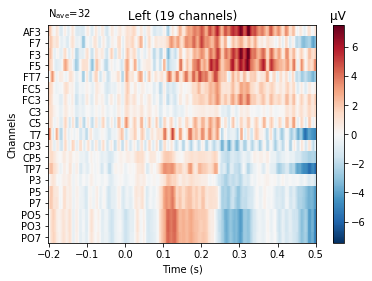

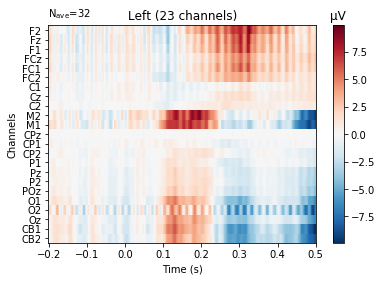

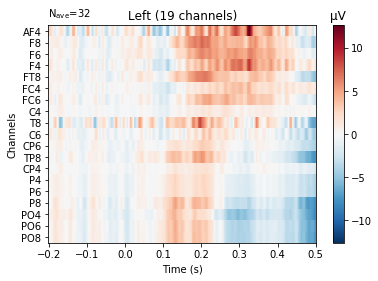

In [49]:
diff.plot_image(group_by=rois, show=False, show_names="all")